# Random Forest - Otimização de Crioprotetores

Importação das bibliotecas necessárias e configuração do ambiente.

In [1]:
import pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Gerenciamento de diretórios e definição de variáveis para as features e target.

In [2]:
BASE_DIR = Path('..').resolve()
FEATURES, TARGET = ['% DMSO', 'TREHALOSE'], '% APÓS O DESCONGELAMENTO'

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8-darkgrid')


### Carregar e preparar dados

Definir o caminho para o arquivo de dados, carregar o dataset e preparar os dados para o modelo. Os dados são divididos em features (X) e target (y), e em seguida, separados em conjuntos de treino e teste.

In [3]:
def safe_float(x):
    s = str(x).replace('%', '').replace(',', '.').strip()
    return float('nan') if s in ('', 'nan') else float(s)

df = pd.read_csv(BASE_DIR / 'data/raw/hepg2.csv', decimal=',', thousands='.')
for col in FEATURES + [TARGET]:
    df[col] = df[col].apply(safe_float)

df = df.dropna(subset=FEATURES + [TARGET])
df = df[~((df[FEATURES[0]] == 0) & (df[FEATURES[1]] == 0))]
df = df[((df[FEATURES] >= 0).all(axis=1)) & ((df[FEATURES] <= 100).all(axis=1))]

X, y = df[FEATURES].values, df[TARGET].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
print(f"Dataset: {len(df)} samples | Train: {len(X_train)} | Test: {len(X_test)}")
print(f"Post-thaw viability: {y.min():.2f}% - {y.max():.2f}% (mean: {y.mean():.2f}%)")

Dataset: 200 samples | Train: 160 | Test: 40
Post-thaw viability: 0.00% - 97.33% (mean: 47.87%)


### Treinar modelo e visualizar performance

Treinar o modelo de Random Forest Regressor, fazer previsões e avaliar a performance utilizando métricas como R², MAE e RMSE. Além disso, criar um gráfico de dispersão para comparar os valores reais e previstos.

RANDOM FOREST PERFORMANCE
R² (Train): 0.9773 | R² (Test): 0.9637
MAE: 4.0900 | RMSE: 6.8694

Feature Importance:
  % DMSO: 74.9%
  TREHALOSE: 25.1%


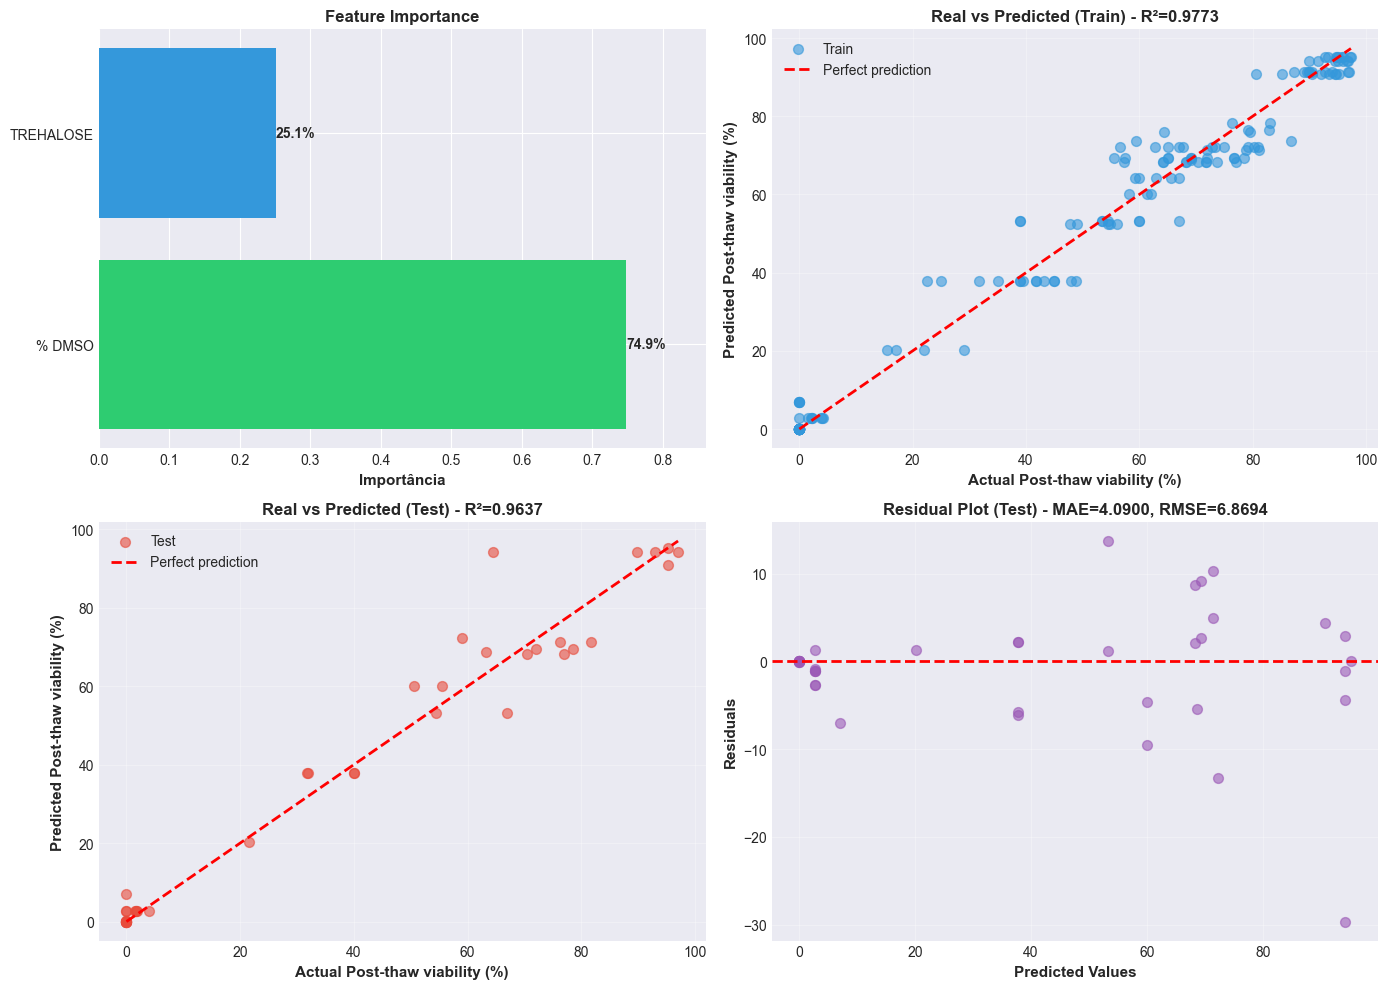

In [5]:
rf = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=3, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred_test = rf.predict(X_test)
r2_train = r2_score(y_train, rf.predict(X_train))
r2_test = r2_score(y_test, y_pred_test)
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("="*50)
print("RANDOM FOREST PERFORMANCE")
print("="*50)
print(f"R² (Train): {r2_train:.4f} | R² (Test): {r2_test:.4f}")
print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f}")
print("\nFeature Importance:")
for feat, imp in zip(FEATURES, rf.feature_importances_):
    print(f"  {feat}: {imp:.1%}")

# Visualizar performance
y_pred_train = rf.predict(X_train)
y_pred_all = rf.predict(X)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Feature Importance
ax = axes[0, 0]
colors = ['#2ecc71', '#3498db']
bars = ax.barh(FEATURES, rf.feature_importances_, color=colors)
ax.set_xlabel('Importância', fontsize=11, fontweight='bold')
ax.set_title('Feature Importance', fontsize=12, fontweight='bold')
ax.set_xlim(0, max(rf.feature_importances_) * 1.15)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, f'{width:.1%}', 
            ha='left', va='center', fontweight='bold', fontsize=10)

# Real vs Predicted (Train)
ax = axes[0, 1]
ax.scatter(y_train, y_pred_train, alpha=0.6, s=50, color='#3498db', label='Train')
min_val, max_val = y_train.min(), y_train.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Real vs Predicted (Train) - R²={r2_train:.4f}', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Real vs Predicted (Test)
ax = axes[1, 0]
ax.scatter(y_test, y_pred_test, alpha=0.6, s=50, color='#e74c3c', label='Test')
min_val, max_val = y_test.min(), y_test.max()
ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Predicted Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_title(f'Real vs Predicted (Test) - R²={r2_test:.4f}', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Residual Plot
ax = axes[1, 1]
residuals = y_test - y_pred_test
ax.scatter(y_pred_test, residuals, alpha=0.6, s=50, color='#9b59b6')
ax.axhline(y=0, color='r', linestyle='--', lw=2)
ax.set_xlabel('Predicted Values', fontsize=11, fontweight='bold')
ax.set_ylabel('Residuals', fontsize=11, fontweight='bold')
ax.set_title(f'Residual Plot (Test) - MAE={mae:.4f}, RMSE={rmse:.4f}', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Avaliar o modelo em um cenário de otimização, utilizando um grid de concentrações de DMSO e trehalose para prever a viabilidade celular e identificar as melhores condições.


OPTIMAL RECOMMENDATION
DMSO: 1% | Trehalose: 0%
Predicted Post-thaw viability: 95.23%

BEST BY SCENARIO (MODEL)
Grid 0-100% (step=1)  -> can include values not in dataset
  DMSO only:      DMSO 1% | Tre 0%  -> 95.23%
  Tre only:       DMSO 0% | Tre 1%  -> 95.23%
  Both together:  DMSO 1% | Tre 1%  -> 95.23%

Restricted to DATABASE observed pairs (only combos that exist in df)
  DMSO only:      DMSO 2% | Tre 0%  -> 95.23%
  Tre only:       DMSO 0% | Tre 20%  -> 71.34%
  Both together:  DMSO 10% | Tre 5%  -> 78.23%

TOP 15 COMBINATIONS:
------------------------------------------------------------
Rank    DMSO   Trehalose    Post-thaw
------------------------------------------------------------
   1      1%          0%       95.23%
   2      2%          0%       95.23%
   3      3%          0%       95.23%
   4      0%          1%       95.23%
   5      2%          1%       95.23%
   6      3%          1%       95.23%
   7      1%          1%       95.23%
   8      2%          2%       9

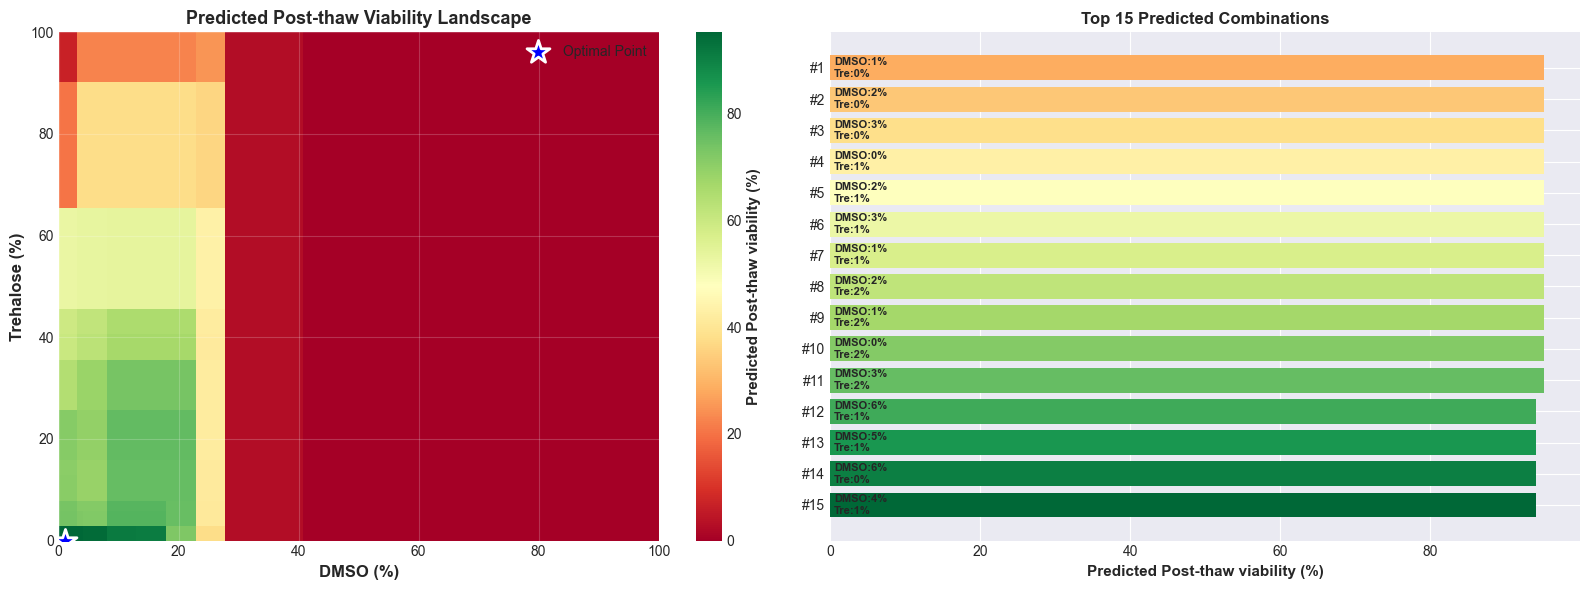

In [6]:
conc = np.arange(0, 101, 1)
grid = np.array(np.meshgrid(conc, conc)).reshape(2, -1).T
y_pred = rf.predict(grid)

valid = ~((grid[:, 0] == 0) & (grid[:, 1] == 0))
best_idx = np.argmax(y_pred[valid])
best_global_idx = np.where(valid)[0][best_idx]

best_dmso, best_tre = grid[best_global_idx]
best_viab = y_pred[best_global_idx]

# ===== Extra: melhores por cenário (GRID 1% - pode incluir valores não observados no dataset) =====
dmso_only_mask = (grid[:, 0] > 0) & (grid[:, 1] == 0)
tre_only_mask = (grid[:, 0] == 0) & (grid[:, 1] > 0)
both_mask = (grid[:, 0] > 0) & (grid[:, 1] > 0)

def best_from_mask(mask: np.ndarray):
    if mask is None or not np.any(mask):
        return None
    local_idx = np.argmax(y_pred[mask])
    global_idx = np.where(mask)[0][local_idx]
    d, t = grid[global_idx]
    viab = y_pred[global_idx]
    return global_idx, d, t, viab

best_dmso_only = best_from_mask(dmso_only_mask)
best_tre_only = best_from_mask(tre_only_mask)
best_both_only = best_from_mask(both_mask)

# ===== Extra: melhores por cenário RESTRITO À DATABASE (somente pares (DMSO,Tre) que existem no dataset) =====
observed_pairs = df[FEATURES].drop_duplicates().to_numpy()
observed_pred = rf.predict(observed_pairs)

# (aqui o alvo é maximizar viabilidade pós-descongelamento)
def best_from_points(points: np.ndarray, pred: np.ndarray, mask: np.ndarray):
    if mask is None or not np.any(mask):
        return None
    local_idx = np.argmax(pred[mask])
    global_idx = np.where(mask)[0][local_idx]
    d, t = points[global_idx]
    viab = pred[global_idx]
    return global_idx, d, t, viab

obs_dmso_only_mask = (observed_pairs[:, 0] > 0) & (observed_pairs[:, 1] == 0)
obs_tre_only_mask = (observed_pairs[:, 0] == 0) & (observed_pairs[:, 1] > 0)
obs_both_mask = (observed_pairs[:, 0] > 0) & (observed_pairs[:, 1] > 0)

best_dmso_only_db = best_from_points(observed_pairs, observed_pred, obs_dmso_only_mask)
best_tre_only_db = best_from_points(observed_pairs, observed_pred, obs_tre_only_mask)
best_both_only_db = best_from_points(observed_pairs, observed_pred, obs_both_mask)

# Mantém o top 15 global
top_idx = np.argsort(-y_pred[valid])[:15]
top_global = np.where(valid)[0][top_idx]

# Matriz de predições e heatmap
viability_matrix = y_pred.reshape(101, 101)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
ax = axes[0]
im = ax.imshow(viability_matrix, cmap='RdYlGn', origin='lower', extent=[0, 100, 0, 100], aspect='auto')
ax.scatter([best_dmso], [best_tre], color='blue', s=300, marker='*', edgecolors='white', linewidths=2, label='Optimal Point', zorder=5)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Predicted Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_xlabel('DMSO (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('Trehalose (%)', fontsize=12, fontweight='bold')
ax.set_title('Predicted Post-thaw Viability Landscape', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.2)
ax.legend(fontsize=10, loc='upper right')

# Top 15 combinações
ax = axes[1]
top_viab = [y_pred[idx] for idx in top_global]
top_labels = [f"DMSO:{grid[idx, 0]:.0f}%\nTre:{grid[idx, 1]:.0f}%" for idx in top_global]
colors_gradient = plt.cm.RdYlGn(np.linspace(0.3, 1, len(top_viab)))
bars = ax.barh(range(len(top_viab)), top_viab, color=colors_gradient)
ax.set_yticks(range(len(top_viab)))
ax.set_yticklabels([f"#{i}" for i in range(1, len(top_viab)+1)])
ax.set_xlabel('Predicted Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_title('Top 15 Predicted Combinations', fontsize=12, fontweight='bold')
ax.invert_yaxis()
for i, (bar, label) in enumerate(zip(bars, top_labels)):
    ax.text(0.5, bar.get_y() + bar.get_height()/2, label, 
            va='center', fontsize=8, fontweight='bold')

print("\n" + "="*50)
print("OPTIMAL RECOMMENDATION")
print("="*50)
print(f"DMSO: {best_dmso:.0f}% | Trehalose: {best_tre:.0f}%")
print(f"Predicted Post-thaw viability: {best_viab:.2f}%")

print("\n" + "="*50)
print("BEST BY SCENARIO (MODEL)")
print("="*50)
print("Grid 0-100% (step=1)  -> can include values not in dataset")
if best_dmso_only is not None:
    _, d, t, v = best_dmso_only
    print(f"  DMSO only:      DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  DMSO only:      (no valid combos)")

if best_tre_only is not None:
    _, d, t, v = best_tre_only
    print(f"  Tre only:       DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  Tre only:       (no valid combos)")

if best_both_only is not None:
    _, d, t, v = best_both_only
    print(f"  Both together:  DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  Both together:  (no valid combos)")

print("\nRestricted to DATABASE observed pairs (only combos that exist in df)")
if best_dmso_only_db is not None:
    _, d, t, v = best_dmso_only_db
    print(f"  DMSO only:      DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  DMSO only:      (no rows with Tre=0 and DMSO>0)")

if best_tre_only_db is not None:
    _, d, t, v = best_tre_only_db
    print(f"  Tre only:       DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  Tre only:       (no rows with DMSO=0 and Tre>0)")

if best_both_only_db is not None:
    _, d, t, v = best_both_only_db
    print(f"  Both together:  DMSO {d:.0f}% | Tre {t:.0f}%  -> {v:.2f}%")
else:
    print("  Both together:  (no rows with DMSO>0 and Tre>0)")

print("\nTOP 15 COMBINATIONS:")
print("-" * 60)
print(f"{'Rank':>4} {'DMSO':>7} {'Trehalose':>11} {'Post-thaw':>12}")
print("-" * 60)
for i, idx in enumerate(top_global, 1):
    d, t = grid[idx]
    v = y_pred[idx]
    print(f"{i:4d} {d:6.0f}% {t:10.0f}% {v:11.2f}%")


plt.tight_layout()
plt.show()

### Comparar com observações e analisar erros


COMPARISON: RF Prediction vs Dataset Observed

Dataset Best Observed:
   DMSO: 2% | Trehalose: 0%
   Post-thaw viability: 97.33% (actual measurement)

Random Forest Recommendation:
   DMSO: 1% | Trehalose: 0%
   Predicted Post-thaw viability: 95.23%

RF prediction for observed best: 95.23%

BEST BY SCENARIO (DATASET OBSERVED vs MODEL)
Observed DMSO only best:      DMSO 2% | Tre 0%  -> 97.33% (RF: 95.23%)
Observed Trehalose only best: DMSO 0% | Tre 20%  -> 81.70% (RF: 71.34%)
Observed Both together best:  DMSO 10% | Tre 30%  -> 86.75% (RF: 73.58%)

Erro Médio: -0.1958%
Desvio Padrão: 5.6798%
Status: Alinhadas!


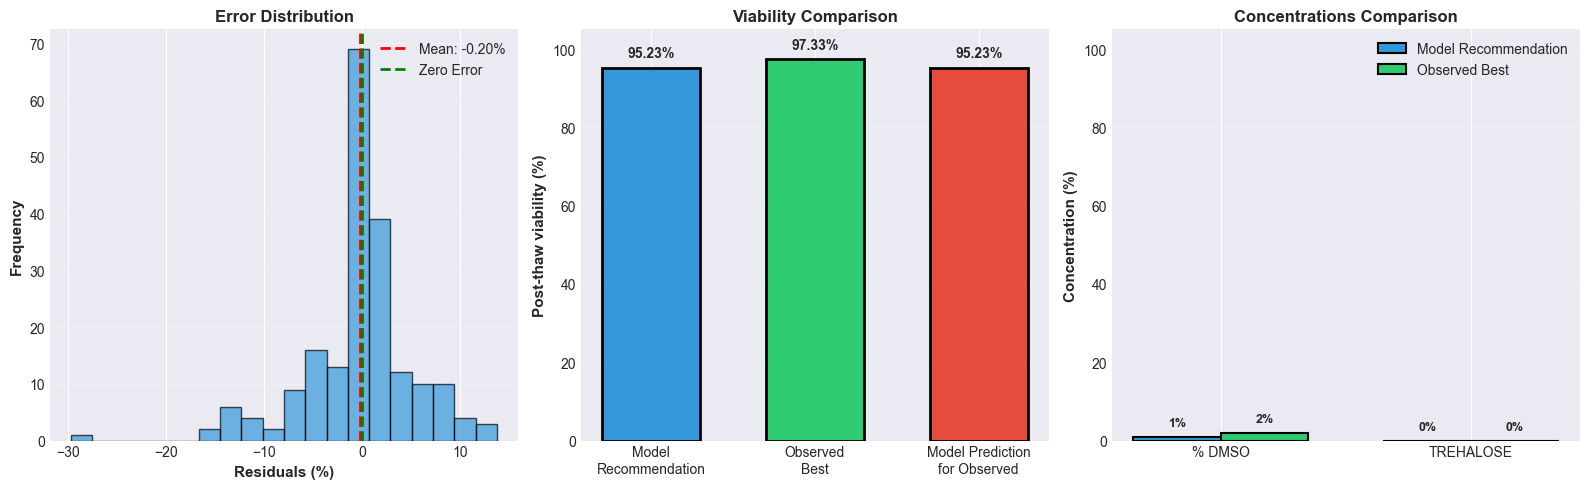

In [7]:
best_obs_idx = df[TARGET].argmax()
best_obs = df.iloc[best_obs_idx]
best_obs_viab = best_obs[TARGET]

test_best = np.array([[best_obs[FEATURES[0]], best_obs[FEATURES[1]]]])
rf_pred_for_best = rf.predict(test_best)[0]

# Distribuição de erros
residuals_all = y - y_pred_all

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Error Distribution
ax = axes[0]
ax.hist(residuals_all, bins=20, color='#3498db', alpha=0.7, edgecolor='black')
ax.axvline(residuals_all.mean(), color='r', linestyle='--', lw=2, label=f'Mean: {residuals_all.mean():.2f}%')
ax.axvline(0, color='g', linestyle='--', lw=2, label='Zero Error')
ax.set_xlabel('Residuals (%)', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title(f'Error Distribution', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Comparação de viabilidades
ax = axes[1]
categories = ['Model\nRecommendation', 'Observed\nBest', 'Model Prediction\nfor Observed']
viabilities = [best_viab, best_obs_viab, rf_pred_for_best]
colors_comp = ['#3498db', '#2ecc71', '#e74c3c']
bars = ax.bar(categories, viabilities, color=colors_comp, edgecolor='black', linewidth=2, width=0.6)
ax.set_ylabel('Post-thaw viability (%)', fontsize=11, fontweight='bold')
ax.set_title('Viability Comparison', fontsize=12, fontweight='bold')
ax.set_ylim(0, 105)
for bar, val in zip(bars, viabilities):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 2, f'{val:.2f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

# Comparação de concentrações
ax = axes[2]
x = np.arange(len(FEATURES))
width = 0.35
bars1 = ax.bar(x - width/2, [best_dmso, best_tre], width, label='Model Recommendation',
               color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, [best_obs[FEATURES[0]], best_obs[FEATURES[1]]], width,
               label='Observed Best', color='#2ecc71', edgecolor='black', linewidth=1.5)
ax.set_ylabel('Concentration (%)', fontsize=11, fontweight='bold')
ax.set_title('Concentrations Comparison', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(FEATURES)
ax.legend()
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, axis='y')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 2, f'{height:.0f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
        
print("\n" + "="*60)
print("COMPARISON: RF Prediction vs Dataset Observed")
print("="*60)
print(f"\nDataset Best Observed:")
print(f"   DMSO: {best_obs[FEATURES[0]]:.0f}% | Trehalose: {best_obs[FEATURES[1]]:.0f}%")
print(f"   Post-thaw viability: {best_obs_viab:.2f}% (actual measurement)")

print(f"\nRandom Forest Recommendation:")
print(f"   DMSO: {best_dmso:.0f}% | Trehalose: {best_tre:.0f}%")
print(f"   Predicted Post-thaw viability: {best_viab:.2f}%")

print(f"\nRF prediction for observed best: {rf_pred_for_best:.2f}%")

# ===== Extra: considerar também o dataset por cenário =====
print(f"\n" + "="*60)
print("BEST BY SCENARIO (DATASET OBSERVED vs MODEL)")
print("="*60)

def best_observed_for(mask: pd.Series):
    sub = df.loc[mask].copy()
    if len(sub) == 0:
        return None
    sub['__score__'] = sub[TARGET]
    row = sub.loc[sub['__score__'].idxmax()]
    return row

def rf_pred_for_row(row: pd.Series):
    x = np.array([[row[FEATURES[0]], row[FEATURES[1]]]])
    return rf.predict(x)[0]

m_dmso_only = (df[FEATURES[0]] > 0) & (df[FEATURES[1]] == 0)
m_tre_only = (df[FEATURES[0]] == 0) & (df[FEATURES[1]] > 0)
m_both = (df[FEATURES[0]] > 0) & (df[FEATURES[1]] > 0)

row_dmso_only = best_observed_for(m_dmso_only)
row_tre_only = best_observed_for(m_tre_only)
row_both = best_observed_for(m_both)

if row_dmso_only is not None:
    obs_v = row_dmso_only[TARGET]
    pred_v = rf_pred_for_row(row_dmso_only)
    print(f"Observed DMSO only best:      DMSO {row_dmso_only[FEATURES[0]]:.0f}% | Tre {row_dmso_only[FEATURES[1]]:.0f}%  -> {obs_v:.2f}% (RF: {pred_v:.2f}%)")
else:
    print("Observed DMSO only best:      (no rows in dataset with Tre=0 and DMSO>0)")

if row_tre_only is not None:
    obs_v = row_tre_only[TARGET]
    pred_v = rf_pred_for_row(row_tre_only)
    print(f"Observed Trehalose only best: DMSO {row_tre_only[FEATURES[0]]:.0f}% | Tre {row_tre_only[FEATURES[1]]:.0f}%  -> {obs_v:.2f}% (RF: {pred_v:.2f}%)")
else:
    print("Observed Trehalose only best: (no rows in dataset with DMSO=0 and Tre>0)")

if row_both is not None:
    obs_v = row_both[TARGET]
    pred_v = rf_pred_for_row(row_both)
    print(f"Observed Both together best:  DMSO {row_both[FEATURES[0]]:.0f}% | Tre {row_both[FEATURES[1]]:.0f}%  -> {obs_v:.2f}% (RF: {pred_v:.2f}%)")
else:
    print("Observed Both together best:  (no rows in dataset with DMSO>0 and Tre>0)")

print(f"\n" + "="*60)
print(f"Erro Médio: {residuals_all.mean():.4f}%")
print(f"Desvio Padrão: {residuals_all.std():.4f}%")
corr_status = 'Alinhadas!' if abs(best_viab - best_obs_viab) < 10 else '✗ Divergentes'
print(f"Status: {corr_status}")

plt.tight_layout()
plt.show()